In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the style
sns.set(style="whitegrid")
sns.set_context("talk")

# Define your files
files = {
    "voom": "rf/results/voom_30_pcs.csv",
    "embeddings_voom": "rf/results/voom_embeddings_30_pcs.csv",
    "embeddings_logTPM": "rf/results/embeddings_30_pcs.csv",
    "embeddings_rawCounts": "rf/results/read_count_embeddings_30_pcs.csv",
}

# Load files into one long-format dataframe
combined_df = pd.DataFrame()


for method, filename in files.items():
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        if "DRUG_ID" in df.columns and "r2_mean" in df.columns:
            df["Method"] = method
            df["Method"] = df["Method"].replace({
    "embeddings_voom": "embeddings\nvoom",
    "embeddings_logTPM": "embeddings\nlogTPM",
    "embeddings_rawCounts": "embeddings\nrawCounts"
})
            combined_df = pd.concat([combined_df, df[["DRUG_ID", "r2_mean", "Method"]]], ignore_index=True)
        else:
            print(f"⚠️ Skipping {filename}: Missing required columns")
    else:
        print(f"⚠️ File not found: {filename}")


/tmp/ipykernel_1371277/2508774174.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Method", y="r2_mean", data=combined_df, palette="Set2")


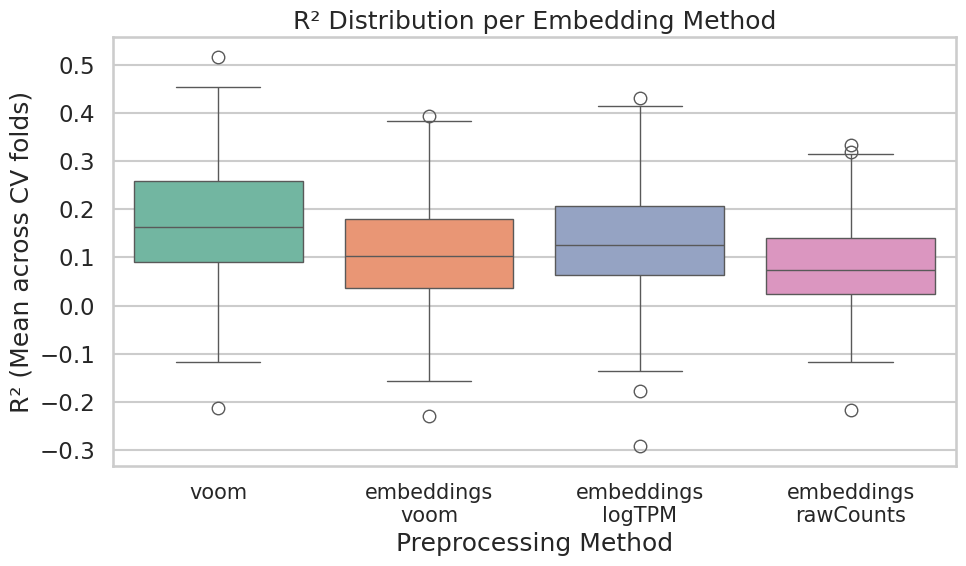

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Method", y="r2_mean", data=combined_df, palette="Set2")
plt.title("R² Distribution per Embedding Method")
plt.ylabel("R² (Mean across CV folds)")
plt.xlabel("Preprocessing Method")
plt.xticks(rotation=0, ha="center", fontsize=15)
plt.tight_layout()
plt.show()


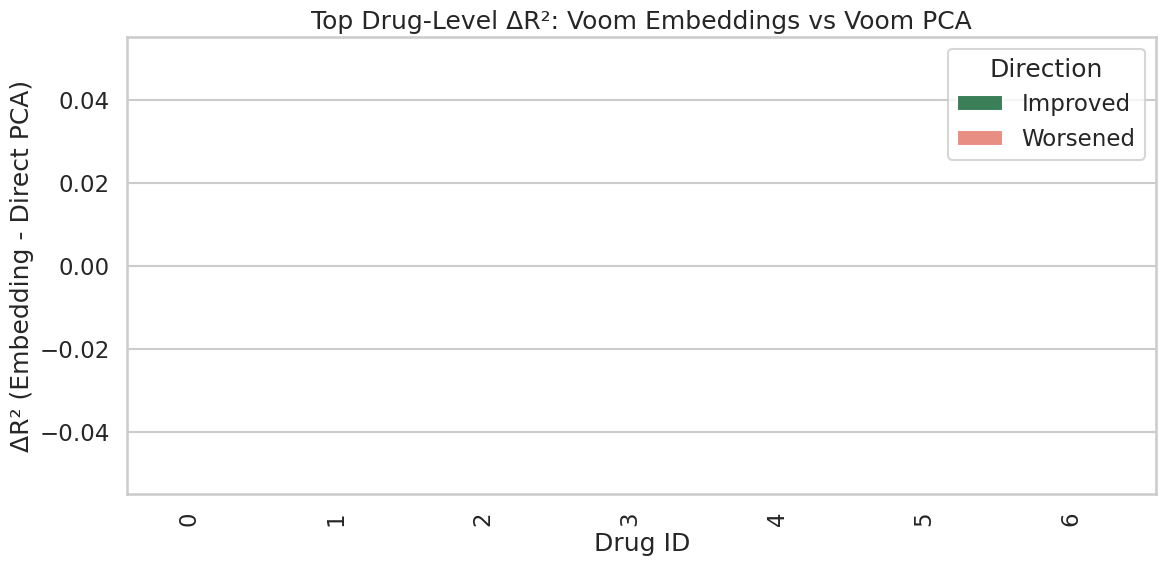

In [32]:
# Compare voom_embeddings vs voom_direct PCA
voom_direct = combined_df[combined_df["Method"] == "voom"].set_index("DRUG_ID")["r2_mean"]
voom_emb = combined_df[combined_df["Method"] == "embeddings_voom"].set_index("DRUG_ID")["r2_mean"]

delta_r2 = (voom_emb - voom_direct).dropna().sort_values(ascending=False)

# Prepare top gainers and worst cases
top_n = 10
delta_df = pd.DataFrame({
    "DRUG_ID": delta_r2.index[:top_n].tolist() + delta_r2.index[-top_n:].tolist(),
    "Delta R²": delta_r2.tolist()[:top_n] + delta_r2.tolist()[-top_n:],
})
delta_df["Direction"] = ["Improved"] * top_n + ["Worsened"] * top_n

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x="DRUG_ID", y="Delta R²", hue="Direction", data=delta_df,
            palette={"Improved": "seagreen", "Worsened": "salmon"})
plt.title("Top Drug-Level ΔR²: Voom Embeddings vs Voom PCA")
plt.ylabel("ΔR² (Embedding - Direct PCA)")
plt.xlabel("Drug ID")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


📊 Mean R² values by method:
                  Method   Mean R²
0                   voom  0.173342
2     embeddings\nlogTPM  0.136204
1       embeddings\nvoom  0.109502
3  embeddings\nrawCounts  0.083394


/tmp/ipykernel_1371277/493800122.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=r2_df, x="Method", y="Mean R²", palette="Set2")


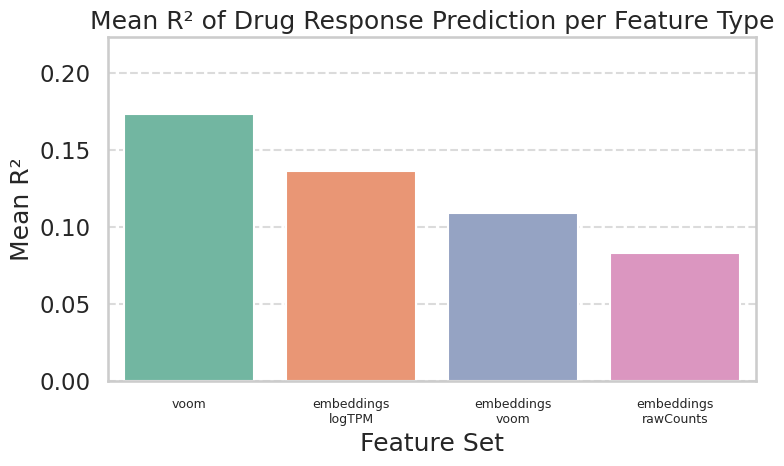

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths to compare
files = {
    "voom": "rf/results/voom_30_pcs.csv",
    "embeddings_voom": "rf/results/voom_embeddings_30_pcs.csv",
    "embeddings_logTPM": "rf/results/embeddings_30_pcs.csv",
    "embeddings_rawCounts": "rf/results/read_count_embeddings_30_pcs.csv",
}

# Calculate mean R² per model
mean_r2_by_model = []
for name, path in files.items():
    df = pd.read_csv(path)
    mean_r2 = df["r2_mean"].mean()
    
    # Add line breaks for long names
    name_pretty = name.replace("embeddings_", "embeddings\n")
    mean_r2_by_model.append((name_pretty, mean_r2))

# Create DataFrame
r2_df = pd.DataFrame(mean_r2_by_model, columns=["Method", "Mean R²"]).sort_values("Mean R²", ascending=False)

# Display results
print("📊 Mean R² values by method:")
print(r2_df)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=r2_df, x="Method", y="Mean R²", palette="Set2")
plt.title("Mean R² of Drug Response Prediction per Feature Type")
plt.ylabel("Mean R²")
plt.xlabel("Feature Set")
plt.ylim(0, r2_df["Mean R²"].max() + 0.05)
plt.xticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [34]:
# Load all results
results = {
    "voom": pd.read_csv("rf/results/voom_30_pcs.csv"),
    "embeddings_voom": pd.read_csv("rf/results/voom_embeddings_30_pcs.csv"),
    "embeddings_logTPM": pd.read_csv("rf/results/embeddings_30_pcs.csv"),
    "embeddings_rawCounts": pd.read_csv("rf/results/read_count_embeddings_30_pcs.csv"),
}

# Merge on DRUG_ID
merged_df = results["voom"][["DRUG_ID", "r2_mean"]].rename(columns={"r2_mean": "voom"})
for name, df in results.items():
    if name != "voom":
        merged_df = merged_df.merge(df[["DRUG_ID", "r2_mean"]].rename(columns={"r2_mean": name}), on="DRUG_ID")

# Compare each method to voom_direct
baseline = "voom"
for method in ["embeddings_voom", "embeddings_logTPM", "embeddings_rawCounts"]:
    delta_col = f"Δ_{baseline}_vs_{method}"
    merged_df[delta_col] = merged_df[baseline] - merged_df[method]
    
    improved = (merged_df[delta_col] > 0).sum()
    worsened = (merged_df[delta_col] < 0).sum()
    unchanged = (merged_df[delta_col] == 0).sum()
    mean_delta = merged_df[delta_col].mean()
    
    print(f"\n📊 Comparison: voom vs. {method}")
    print(f"Drugs where voom is better: {improved}")
    print(f"Drugs where voom is worse: {worsened}")
    print(f"Unchanged: {unchanged}")
    print(f"Mean ΔR² (voom - {method}): {mean_delta:.4f}")



📊 Comparison: voom vs. embeddings_voom
Drugs where voom is better: 670
Drugs where voom is worse: 27
Unchanged: 0
Mean ΔR² (voom - embeddings_voom): 0.0638

📊 Comparison: voom vs. embeddings_logTPM
Drugs where voom is better: 590
Drugs where voom is worse: 107
Unchanged: 0
Mean ΔR² (voom - embeddings_logTPM): 0.0371

📊 Comparison: voom vs. embeddings_rawCounts
Drugs where voom is better: 681
Drugs where voom is worse: 16
Unchanged: 0
Mean ΔR² (voom - embeddings_rawCounts): 0.0899


/tmp/ipykernel_1371277/1206432887.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined, x="Method", y="r2_mean", palette="Set2")


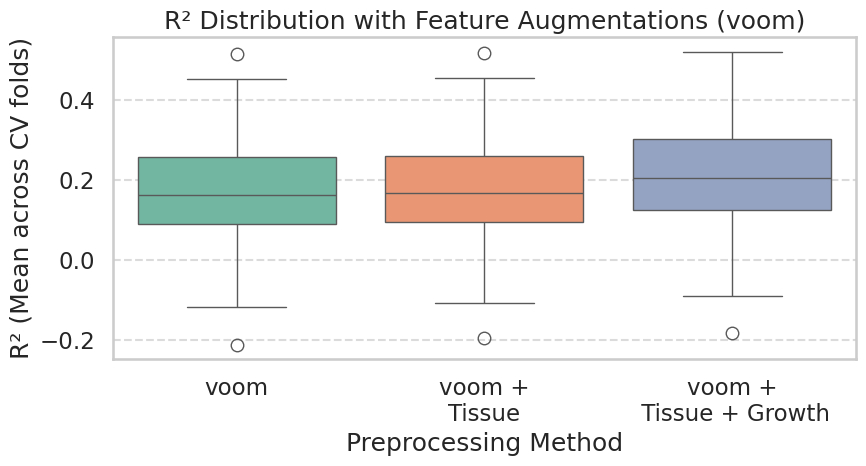

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load performance results
df_base = pd.read_csv("rf/results/voom_30_pcs.csv")
df_tissue = pd.read_csv("rf/results/voom_30_pcs_tissue.csv")
df_full = pd.read_csv("rf/results/voom_30_pcs_tissue_growth.csv")

# Add a method column to each
df_base["Method"] = "voom"
df_tissue["Method"] = "voom +\nTissue"
df_full["Method"] = "voom +\n Tissue + Growth"

# Combine
combined = pd.concat([df_base, df_tissue, df_full], ignore_index=True)

# Plot
plt.figure(figsize=(9, 5))
sns.boxplot(data=combined, x="Method", y="r2_mean", palette="Set2")
plt.title("R² Distribution with Feature Augmentations (voom)")
plt.xlabel("Preprocessing Method")
plt.ylabel("R² (Mean across CV folds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [36]:
import pandas as pd

# Load the relevant results
df_base = pd.read_csv("rf/results/voom_30_pcs.csv")[["DRUG_ID", "r2_mean"]].rename(columns={"r2_mean": "R2_base"})
df_tissue = pd.read_csv("rf/results/voom_30_pcs_tissue.csv")[["DRUG_ID", "r2_mean"]].rename(columns={"r2_mean": "R2_tissue"})
df_full = pd.read_csv("rf/results/voom_30_pcs_tissue_growth.csv")[["DRUG_ID", "r2_mean"]].rename(columns={"r2_mean": "R2_full"})

# Merge all
merged = df_base.merge(df_tissue, on="DRUG_ID").merge(df_full, on="DRUG_ID")

# Mean R² per version
mean_r2 = merged[["R2_base", "R2_tissue", "R2_full"]].mean()
print("📊 Mean R² per model:")
print(mean_r2.sort_values(ascending=False))

# Compute ΔR²
merged["Δ_tissue"] = merged["R2_tissue"] - merged["R2_base"]
merged["Δ_full"] = merged["R2_full"] - merged["R2_base"]

# Report
for label, delta_col in {
    "PCA → PCA + Tissue": "Δ_tissue",
    "PCA → PCA + Tissue + Growth": "Δ_full"
}.items():
    print(f"\n📈 Random Forest: {label}")
    print(f"Improved: {(merged[delta_col] > 0).sum()}")
    print(f"Worsened: {(merged[delta_col] < 0).sum()}")
    print(f"Mean ΔR²: {merged[delta_col].mean():.4f}")


📊 Mean R² per model:
R2_full      0.213672
R2_tissue    0.177765
R2_base      0.173342
dtype: float64

📈 Random Forest: PCA → PCA + Tissue
Improved: 483
Worsened: 214
Mean ΔR²: 0.0044

📈 Random Forest: PCA → PCA + Tissue + Growth
Improved: 601
Worsened: 96
Mean ΔR²: 0.0403
